In [1]:
import pandas as pd
from datetime import datetime
from bitarray import bitarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn
import bisect
import copy
import re
import time
from datetime import datetime

plt.rcParams["figure.figsize"] = (5,3)

In [2]:
def save_fig(fn):
     plt.tight_layout()
     plt.savefig(fn, metadata={'CreationDate': None})

In [3]:
CONFIG = {}

CONFIG['DATA_FILE'] = "21_28_02_2022_idle_nodes.txt"

# The data file was generated using the following command
# while true; do date +%s; sinfo -h -p lowprio | grep idle; echo "----"; sleep 10s; done | tee -a log.txt

CONFIG['DATA_LATER_THAN'] = datetime(2022, 2, 21)
CONFIG['DATE_EARLIER_THAN'] = datetime(2022, 2, 28)

In [4]:
def expand(s):
    r = s.group().split("-")
    l, r = int(r[0]), int(r[1])
    s = []
    for i in range(l, r+1):
        s.append("%04d" % i)
    return ",".join(s)

idleness_records = []
max_node_id = 0

with open(CONFIG['DATA_FILE'], 'r') as log:
    # Read timestamp
    timestamp = log.readline()

    while timestamp:
        # Convert timestamp to integer
        timestamp = int(timestamp)

        idle_nodes = []

        line = log.readline()
        while line != "----\n":
            # Read the list of nodes
            line = line.split()
            type, record = line[4], line[5]

            # We are only interested in type "idle"
            if type == "idle":
                # Clean the record
                record = record[1:]
                if record[0] == "[":
                    record = record[1:-1]

                # Extract node ids
                record = re.sub("[0-9]{4}-[0-9]{4}", expand, record).split(",")
                idle_nodes = idle_nodes + list(map(lambda x: int(x), record))

                if max(idle_nodes) > max_node_id:
                    max_node_id = max(idle_nodes)
            
            line = log.readline()

        # We are only interested in certain timestamps
        if timestamp >= int(time.mktime(CONFIG['DATA_LATER_THAN'].timetuple())) and timestamp < int(time.mktime(CONFIG['DATE_EARLIER_THAN'].timetuple())):
            idleness_records.append({
                "timestamp" : datetime.fromtimestamp(timestamp),
                "idle_nodes" : idle_nodes
            })

        # Read the next timestamp
        timestamp = log.readline()

In [5]:
CONFIG['DATA_WIDTH'] = len(idleness_records)
CONFIG['DATA_HEIGHT'] = max_node_id + 1 # Some of the nodes were never idle in the measured period, so this number is less than the number of all the nodes in the cluster
CONFIG['MEASURE_DISTANCE'] = (idleness_records[-1]["timestamp"] - idleness_records[0]["timestamp"]).total_seconds() / (CONFIG['DATA_WIDTH'] - 1)

CONFIG['DATA_WIDTH'], CONFIG['DATA_HEIGHT'], CONFIG['MEASURE_DISTANCE']

(58629, 2168, 10.315702394760184)

In [6]:
RESOURCES = {}

In [7]:
# Convert df to a list of idle intervals
RESOURCES['initial_node_status'] = {}

# Create empty bitarrays for all nodes
for node in range(CONFIG['DATA_HEIGHT']):
    RESOURCES['initial_node_status'][node] = bitarray(CONFIG['DATA_WIDTH'])
    RESOURCES['initial_node_status'][node].setall(0)

for timepoint in range(CONFIG['DATA_WIDTH']):
    for node in idleness_records[timepoint]["idle_nodes"]:
        RESOURCES['initial_node_status'][node][timepoint] = 1

In [8]:
RESOURCES['total_number_of_measurements'] = CONFIG['DATA_WIDTH'] * CONFIG['DATA_HEIGHT']
RESOURCES['total_number_of_measurements__busy'] = sum([RESOURCES['initial_node_status'][node].count(0) for node in range(CONFIG['DATA_HEIGHT'])])
RESOURCES['total_number_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements'] - RESOURCES['total_number_of_measurements__busy']
RESOURCES['share_of_measurements__busy'] = \
    RESOURCES['total_number_of_measurements__busy'] / RESOURCES['total_number_of_measurements']
RESOURCES['share_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements__idle'] / RESOURCES['total_number_of_measurements']

In [9]:
RESOURCES['share_of_measurements__idle']

0.004257445608790632

# Question 1

## How many nodes are free at each measurement?

In [10]:
MID_RESULTS = {}
MID_RESULTS['number_of_free_nodes_each_point'] = \
    [sum(item) for item in zip(*[RESOURCES['initial_node_status'][node] for node in range(CONFIG['DATA_HEIGHT'])])]

In [11]:
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.25))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.5))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.75))
print(np.mean(MID_RESULTS['number_of_free_nodes_each_point']))
print(MID_RESULTS['number_of_free_nodes_each_point'].count(0) / CONFIG["DATA_WIDTH"])

2.0
5.0
11.0
9.23014207985809
0.10114448481127088


In [12]:
# Find the longest sequence of zeros
lengths = []

l = 0
for n in MID_RESULTS['number_of_free_nodes_each_point']:
    if n == 0:
        l = l + 1
    else:
        if l > 0:
            lengths.append(l)
        l = 0
if l > 0:
    lengths.append(l)

print(np.max(lengths))
print(np.mean(lengths))
print(np.quantile(lengths, 0.5))

544
16.246575342465754
5.0


In [13]:
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.25))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.5))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.75))

2.0
5.0
11.0


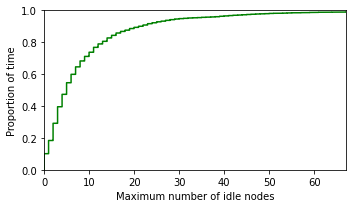

In [14]:
s = seaborn.ecdfplot(MID_RESULTS['number_of_free_nodes_each_point'], color = 'green')
s.set(xlabel='Maximum number of idle nodes', ylabel='Proportion of time')
s.set(xlim=(0, 67))

save_fig("00 - Introductory analysis - Idle nodes - Idle nodes CDF.pdf")
pass

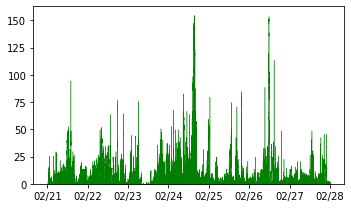

In [15]:
_, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

s = plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), MID_RESULTS['number_of_free_nodes_each_point'], color = 'green', linewidth = 0.4)

save_fig("00 - Introductory analysis - Idle nodes - Idle nodes TS.pdf")
pass

# Question 2

## How long are the periods of idleness?

In [16]:
def ll(r):
    q = []
    l = 0
    for bit in range(len(r)):
        if r[bit] == 1:
            l += 1
        elif l > 0:
            q.append(l)
            l = 0
    if l > 0:
        q.append(l)
    return q

MID_RESULTS['idleness_periods'] = \
    [item for lst in [ll(RESOURCES['initial_node_status'][node]) for node in range(CONFIG['DATA_HEIGHT'])] for item in lst]   

In [17]:
print(np.quantile(MID_RESULTS['idleness_periods'], 0.25)*CONFIG['MEASURE_DISTANCE'])
print(np.quantile(MID_RESULTS['idleness_periods'], 0.5)*CONFIG['MEASURE_DISTANCE'])
print(np.quantile(MID_RESULTS['idleness_periods'], 0.75)*CONFIG['MEASURE_DISTANCE'])
print(np.mean(MID_RESULTS['idleness_periods'])*CONFIG['MEASURE_DISTANCE'])

61.8942143685611
123.7884287371222
237.2611550794842
334.99661628264835


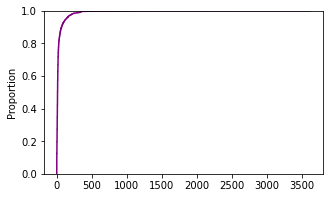

In [18]:
seaborn.ecdfplot(MID_RESULTS['idleness_periods'], color = 'purple')
pass

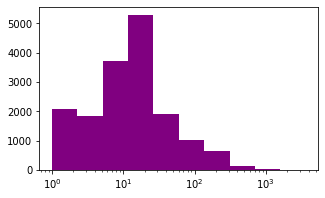

In [19]:
def plot_loghist(x, bins):
  _, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins, color = 'purple')
  plt.xscale('log')

plot_loghist(MID_RESULTS['idleness_periods'], bins=10)

# Question 3

## Simulation

In [20]:
def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect.bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError

In [21]:
# Worker lengths in minutes
SIMULATION_VARIANTS = {
    "A1" : [2, 4, 6, 8, 14, 22, 34, 56, 90],
    "A2" : [2, 4, 8, 12, 20, 34, 54, 88],
    "A3" : [2, 4, 6, 10, 16, 26, 42, 68, 110],
    "B"  : [2, 4, 8, 16, 32, 64],
    "C1" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    "C2" : [2*i for i in range(1,61)]
}

In [22]:
# Set warmup time (measurements)
WORKER_WARMUP_TIME = 2
SIMULATION_VARIANT = "A1"

# Scaled worker lengths (measurements)
WORKER_LENGTHS = [x*6 for x in SIMULATION_VARIANTS[SIMULATION_VARIANT]]

In [23]:
ms = sum(map(lambda x: max(0, x - WORKER_WARMUP_TIME), MID_RESULTS['idleness_periods']))/RESOURCES['total_number_of_measurements__idle']
print("Maximum possible share of idle time used as ready:", ms)

Maximum possible share of idle time used as ready: 0.9410315732674988


In [24]:
MID_RESULTS['simulation'] = {}

In [25]:
import copy
MID_RESULTS['simulation']['availability_status'] = copy.deepcopy(RESOURCES['initial_node_status'])

for node in range(CONFIG['DATA_HEIGHT']):
    MID_RESULTS['simulation']['availability_status'][node] = \
        MID_RESULTS['simulation']['availability_status'][node].tolist()

In [26]:
MID_RESULTS['simulation']['total_warmup_time'] = 0
MID_RESULTS['simulation']['total_ready_time'] = 0
MID_RESULTS['simulation']['total_worker_jobs'] = 0

In [27]:
# Go through all the nodes and simulate the warming up
node_counter = 0
for node in range(CONFIG['DATA_HEIGHT']):
    i = 0
    
    node_counter += 1
    # print("[Simulating node %i/%i: %s]" % (node_counter, CONFIG['DATA_HEIGHT'], node))
    
    while i < CONFIG['DATA_WIDTH']:
        start_index = i        
        # Find the length of the period of ones
        while i < CONFIG['DATA_WIDTH'] and MID_RESULTS['simulation']['availability_status'][node][i] == 1:
            i += 1
        end_index = i
        i += 1
                
        # If the period has non-zero length
        while end_index - start_index >= min(WORKER_LENGTHS):
            max_container = find_le(WORKER_LENGTHS, end_index - start_index)
            # print("\tFound promising space %i, putting OW job of length %i" % (end_index - start_index, max_container))
            MID_RESULTS['simulation']['availability_status'][node][start_index:(start_index + WORKER_WARMUP_TIME)] = [2] * WORKER_WARMUP_TIME
            MID_RESULTS['simulation']['availability_status'][node][start_index + WORKER_WARMUP_TIME:start_index + max_container] = [3] * (max_container - WORKER_WARMUP_TIME)
            
            MID_RESULTS['simulation']['total_warmup_time'] += WORKER_WARMUP_TIME
            MID_RESULTS['simulation']['total_ready_time'] += (max_container - WORKER_WARMUP_TIME)
            MID_RESULTS['simulation']['total_worker_jobs'] += 1
            
            start_index += max_container
        
        # if end_index - start_index > 0:
        #     print("\tNode left free for %i periods [%i, %i)" % (end_index - start_index, start_index, end_index))

In [28]:
print(MID_RESULTS['simulation']['total_warmup_time']*CONFIG['MEASURE_DISTANCE'])
print(MID_RESULTS['simulation']['total_ready_time']*CONFIG['MEASURE_DISTANCE'])
print(MID_RESULTS['simulation']['total_worker_jobs']*CONFIG['MEASURE_DISTANCE'])

222138.33536876578
4498533.394521389
111069.16768438289


In [29]:
z = tuple(zip(*[MID_RESULTS['simulation']['availability_status'][node] for node in range(CONFIG['DATA_HEIGHT'])]))
MID_RESULTS['simulation']['status_summary'] = [[item.count(i) for item in z] for i in range(4)]

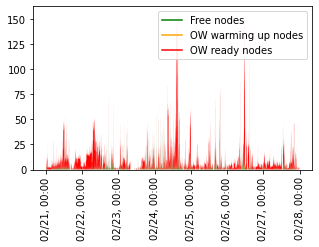

In [30]:
_, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d, %H:%M'))
plt.xticks(rotation = 90)

plt.plot([], [], color='green', label='Free nodes')
plt.plot([], [], color='orange', label='OW warming up nodes')
plt.plot([], [], color='red', label='OW ready nodes')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), MID_RESULTS['simulation']['status_summary'][1:4], colors=['green', 'orange', 'red'])

plt.legend()
plt.show()
pass

In [31]:
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.25))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.5))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.75))
print(np.mean(MID_RESULTS['simulation']['status_summary'][3]))

2.0
4.0
8.0
7.4380596633065545


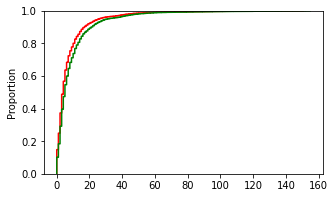

In [32]:
seaborn.ecdfplot(MID_RESULTS['simulation']['status_summary'][3], color = 'red')
seaborn.ecdfplot(MID_RESULTS['number_of_free_nodes_each_point'], color = 'green')
pass

In [33]:
print("Share of idle time used as ready:", MID_RESULTS['simulation']['total_ready_time']/RESOURCES['total_number_of_measurements__idle'])
print("Share of idle time used as warmup:", MID_RESULTS['simulation']['total_warmup_time']/RESOURCES['total_number_of_measurements__idle'])
print("Share of idle time not used:", 1 - (MID_RESULTS['simulation']['total_warmup_time'] + MID_RESULTS['simulation']['total_ready_time'])/RESOURCES['total_number_of_measurements__idle'])
print("Number of seconds where no OW worker was ready:", MID_RESULTS['simulation']['status_summary'][3].count(0))
print("Share of time where no OW worker was ready:", MID_RESULTS['simulation']['status_summary'][3].count(0)/CONFIG['DATA_WIDTH'])
print("Average number of ready nodes: ", (MID_RESULTS['simulation']['total_ready_time']/RESOURCES['total_number_of_measurements__idle']) * (sum(MID_RESULTS['number_of_free_nodes_each_point'])/CONFIG['DATA_WIDTH']))

Share of idle time used as ready: 0.805844547023583
Share of idle time used as warmup: 0.03979273922025893
Share of idle time not used: 0.15436271375615818
Number of seconds where no OW worker was ready: 8687
Share of time where no OW worker was ready: 0.14816899486602195
Average number of ready nodes:  7.438059663306555
